                                                            SIT731 Data Wrangling: Task 8HD
                                                       
Studentname: Van An Duong

StudentID: 223603395

Email: s223603395@deakin.edu.au

Unit course: SIT731 (postgraduate)

I/ Introduction

In task 8HD, the report will analyse data from the History Stack Exchange page. It will analyze the most used tags on the forum, the names that are mentioned a lot, the change in the number of badges over time, the names of countries that are mentioned a lot in comments, and finally the countries has the most posts on the forum.

II/ Pre process data

1/ Import libraries

In [41]:
import pandas as pd
import re
import xml.etree.ElementTree as ET
import csv
from geopy.geocoders import Nominatim
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pycountry
from tqdm import tqdm
from ipywidgets import widgets, interactive, IntSlider

2/ Convert all datafiles to csv and add them into dataframe

In [42]:
def xml_to_csv(input_file, output_file):
    tree = ET.parse(input_file)
    root = tree.getroot()
    
    all_keys = set()
    for element in root.findall('.//row'):
        all_keys.update(element.attrib.keys())
    
    
    header = list(all_keys)
    
    with open(output_file, 'w', newline='', encoding='utf-8') as csv_file:
        csvwriter = csv.writer(csv_file)
        csvwriter.writerow(header)
        for element in root.findall('.//row'):
            row_data = [element.attrib.get(key, '') for key in header]
            csvwriter.writerow(row_data)

xml_to_csv('Votes.xml', 'Votes.csv')
xml_to_csv('Users.xml', 'Users.csv')
xml_to_csv('Tags.xml', 'Tags.csv')
xml_to_csv('PostLinks.xml', 'PostLinks.csv')
xml_to_csv('PostHistory.xml', 'PostHistory.csv')
xml_to_csv('Comments.xml', 'Comments.csv')
xml_to_csv('Badges.xml', 'Badges.csv')
xml_to_csv('Posts.xml', 'Posts.csv')

3/ Read csv

In [43]:
# Read csv
badges = pd.read_csv("Badges.csv")
comments = pd.read_csv("Comments.csv")
postLinks = pd.read_csv("PostLinks.csv")
users = pd.read_csv("Users.csv")
votes = pd.read_csv("Votes.csv")
tags = pd.read_csv("Tags.csv")
postHis = pd.read_csv("PostHistory.csv")
posts = pd.read_csv("Posts.csv")

III/ Analysis

1/ Tags are used a lot on websites

First, I draw a treemap chart to find out which tags were used a lot on the website. 

In [44]:
# Convert TagName and Count column to list
tag = tags['TagName'].tolist() 
count = tags['Count'].tolist()  

def make_treemap(number_of_tags):
    top_tags = tag[:number_of_tags]
    top_counts = count[:number_of_tags]
    
    # Draw treemap
    fig = go.Figure(go.Treemap(labels=top_tags, parents=[""] * len(top_tags), values=top_counts, textinfo="label+value", marker=dict(colors=top_counts, colorscale='Viridis')))
    
    # Modify layout
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25)) 
    
    # Show map
    fig.show()

# Create slider widget for reader to modify the number of tags 
slider = IntSlider(min=1, max=len(tag), step=1, value=20, description='Number of Tags',)

# Create interactive widget 
interactive_widget = interactive(make_treemap, number_of_tags=slider)

# Show slider and treemap
interactive_widget

interactive(children=(IntSlider(value=20, description='Number of Tags', max=89, min=1), Output()), _dom_classe…

The chart shows that the most used tags are discussion, support, and tags. 

2/ The most mentioned names 

Word cloud chart will display the most mentioned names in comments on posts.

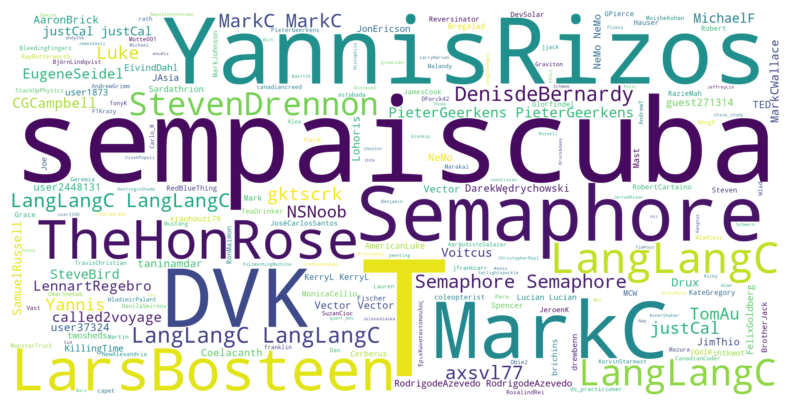

In [45]:
# Use join to concatenate them into one string
combinedString = ' '.join(comments['Text'])

# Use regular expression to find @usernames and concatenate them
usernames = ' '.join(re.findall(r'@(\w+)', combinedString, flags=re.IGNORECASE))

# Draw word cloud
wordcloud = WordCloud(width = 2000, height = 1000, background_color ='white').generate(usernames)

# Show word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

The chart shows that names like Sempaiscuba, YannisRizos, LangLang C, etc.. appear quite a lot in comments. It suggests that these may be people who often interact on the historical forum.

3/ Changes in the number of badges over the years

To find out how the number of badges awarded changes, I will draw a line chart.

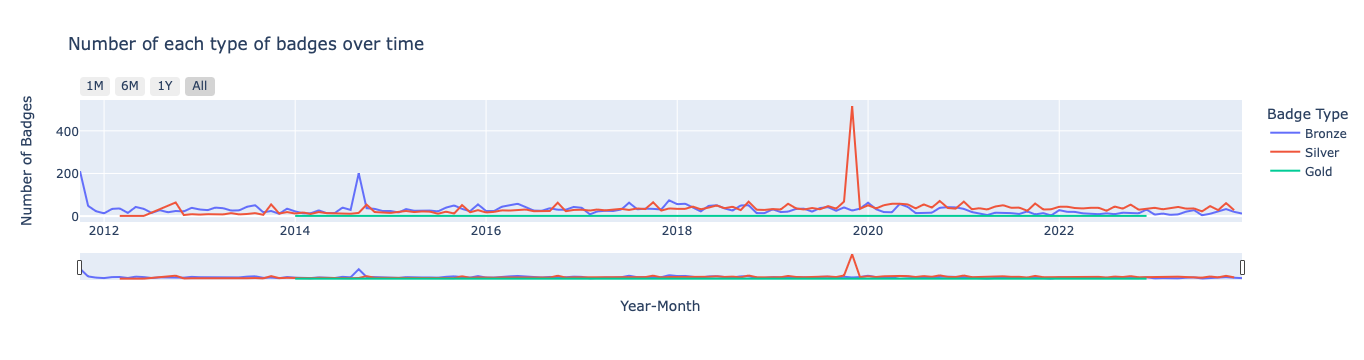

In [46]:
# Define a new column contains types of badges
value_to_badges = {
    1: 'Gold',
    2: 'Silver',
    3: 'Bronze'
}
badges['ClassType'] = badges['Class'].map(value_to_badges) 

#Add a Count column to count rows group by ClassType column
badges['Count'] = badges.groupby('ClassType').size().reset_index(drop=True)

# Use regular expression to extract year and month 
badges['YearMonth'] = badges['Date'].str.extract(r'^(\d{4}-\d{2})')

# Count badges group by YearMonth and ClassType
badge_counts = badges.groupby(['YearMonth', 'ClassType']).size().reset_index(name='Count')

# Create an interactive line chart 
fig = px.line(badge_counts, x='YearMonth', y='Count', color='ClassType', title='Number of each type of badges over time',
              labels={'YearMonth': 'Year-Month', 'Count': 'Number of Badges', 'ClassType': 'Badge Type'},
              markers=False)

# Update the layout to add a date range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1M", step="month", stepmode="backward"),
                dict(count=6, label="6M", step="month", stepmode="backward"),
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(step="all", label="All"),
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

# Show the chart with slider
fig.show()

On the chart, the number of silver badges increased the most and remained steady in every year. Meanwhile, the number of yellow badges is very small and tends to decrease.

4/ Name of countries mentioned most in comments

In this section, I will draw a bar chart to find out which countries are mentioned a lot in comments. Viewers can adjust the number of countries on the slider if they want.

In [47]:
# Remove duplicate comments and reset the index
task4 = comments.loc[:, 'Text'].drop_duplicates().reset_index(drop=True).to_frame()

# Create a set of all country names from pycountry
country_names = set(country.name for country in pycountry.countries)

# Extract country name from special character and match them
extracted_country_names = '|'.join(re.escape(country) for country in country_names)

# Use regular expression to find countries
country_pattern = r'\b(?:' + extracted_country_names + r')\b'

# Extract country names from the 'Text' column
task4['extracted_countries'] = task4['Text'].str.findall(country_pattern, flags=re.IGNORECASE)

# Flatten the lists of extracted countries and drop missing values
flattened_countries = task4.explode('extracted_countries')['extracted_countries'].dropna()

# Normalize country names by converting to lowercase and stripping whitespace
flattened_countries = flattened_countries.str.lower().str.strip()

# Count the occurrences of each normalized country
country_counts = flattened_countries.value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Convert country names back to title case 
country_counts['Country'] = country_counts['Country'].str.title()

# Draw a plot for the top n mentioned countries
def plot_countries(n):
    top_countries = country_counts.head(n)
    fig = go.Figure(data=[go.Bar(x=top_countries['Country'], y=top_countries['Count'], marker_color='blue')])
    fig.update_layout(title_text=f'Top {n} Mentioned Countries', xaxis_title='Country', yaxis_title='Count')
    fig.show()

# Create a slider widget to choose the number of countries to display
slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='Number of Countries:', continuous_update=False)

# Use interactive widget to link the plot function with the slider
interactive_plot = interactive(plot_countries, n=slider)

# Display the plot and slider
display(interactive_plot)


interactive(children=(IntSlider(value=5, continuous_update=False, description='Number of Countries:', max=20, …

In comments, the most mentioned countries are: Germany, Japan, France, China, and Spain. It suggests that they have influenced on modern history.

5/ Countries around the world have many posts on the forum

In this section, I will draw a map to find the places in the world with the most posts.

Geocoding locations: 100%|██████████| 6011/6011 [1:28:12<00:00,  1.14it/s]  


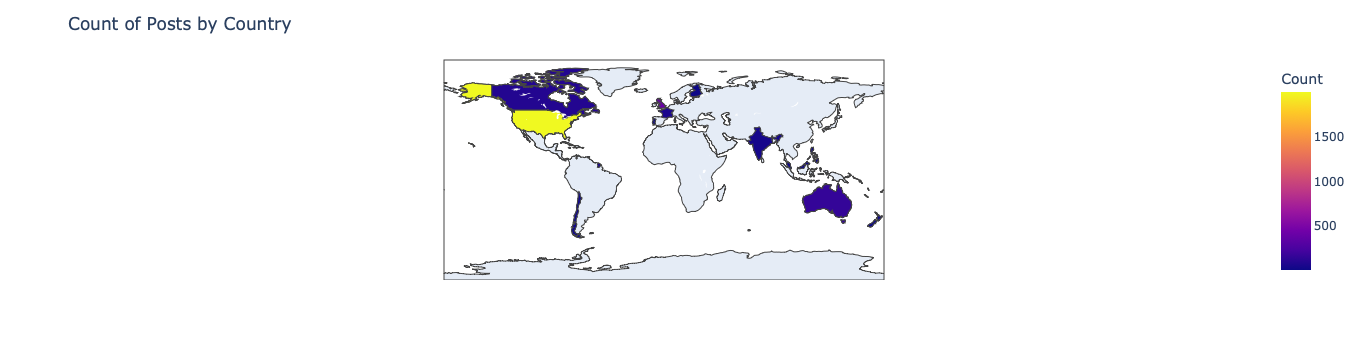

In [33]:
task5 = pd.merge(users, postHis, left_on="Id", right_on="UserId")

# Initialize geolocator
geolocator = Nominatim(user_agent="geoapiExercises")

# Extract country from location
def get_country(location):
    try:
        return geolocator.geocode(location, addressdetails=True).raw['address']['country']
    except:
        return None

# Apply function to each location 
task5['Country'] = [get_country(loc) for loc in tqdm(task5['Location'], desc="Geocoding locations")]

# Count post group by Country
posts_count = task5.groupby('Country').size().reset_index(name='Count')

# Plotting
fig = px.choropleth(posts_count, locations="Country", locationmode="country names", color="Count", hover_name="Country", color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title_text='Count of Posts by Country')
fig.show()

The map chart displays that the US is the country with the most posts on the forum, followed by the UK and Australia. Meanwhile, other countries usually have no more than 100 posts.

6/ Data privacy

The report is allowed to download data from https://archive.org/details/stackexchange. In addition, the report also limits analysis of sensitive user data such as their accountID, profile, and website.

IV/ Conclusion

Through the above report, it has shown the most used tags on the forum, the most mentioned users, the number of badges that change over time, the countries that are mentioned a lot in comments, and the countries that are frequently mentioned. Gia has many posts. It generally describes how users in different places are using the forum.